In [2]:
import math
from math import gcd
import numpy as np
import itertools
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random

In [3]:
class TaskSet:
    
    
    def __init__(self):
        
        # Initializing empty local array of tasks array
        self.__tasks = []

        
    def addTask(self, period, deadline, computeTime, phase):
        
        # Adding a task to the array of tasks
        self.__tasks.append({'period': period, 'deadline': deadline, 'computeTime': computeTime, 'phase': phase})

        
    def removeTask(self, index):
        
        # Deleting a task at index
        del self.__tasks[index]

        
    def getTask(self, index):
        
        # Return a task at certain index
        return self.__tasks[index]

    
    def getAllTasks(self):
        
        # Return all tasks
        return self.__tasks

    
    def size(self):
        
        # Returns number of tasks in the taskset
        return len(self.__tasks)
    
    
    def updatePhases(self, phase_array):
        
        # Updating phases of all tasks
        for i in range(len(phase_array)):
            self.__tasks[i]['phase'] = phase_array[i]

            
            

In [4]:
class CyclicExecutiveSchedule:
    
    
    def __init__(self, task_set):
        
        # Creating local copy of task_set object
        self.task_set = task_set
        
        # Calculating hyperperiod for the given task_set
        self.hyperperiod = self.compute_hyperperiod()
        
        # Cacluating all valid frame sizes
        self.valid_frames = self.compute_valid_frames()
        
        # Making an array of periods of all tasks in the taskset
        periods = [task['period'] for task in self.task_set.getAllTasks()]
        
        # Making an array of compute times of all tasks in the taskset
        compute_times = [task['computeTime'] for task in self.task_set.getAllTasks()]
        
        # Computing utilization factor
        self.utilization = 0
        for i in range(len(compute_times)):
            self.utilization += (compute_times[i] / periods[i])
        
        # Basic check that utilization factor does not exceed 100%, otherwise give warning
        if self.utilization>1:
            print("Utilization is "+str(self.utilization*100)+" % and It cannot be scheduled.")
        
        
    def compute_hyperperiod(self):
        
        # Making an array of periods of all tasks in the taskset
        periods = [task['period'] for task in self.task_set.getAllTasks()]
        
        # Returning hyperperiod of all tasks in the taskset
        return math.lcm(*periods)

    
    def compute_valid_frames(self):
        
        # Making an array of periods of all tasks in the taskset
        periods = [task['period'] for task in self.task_set.getAllTasks()]
        
        # Making an array of compute times of all tasks in the taskset
        compute_times = [task['computeTime'] for task in self.task_set.getAllTasks()]
        
        # Finding out the minimum time period of a task in the taskset
        min_period = min(periods)
        
        # Finding out the maximum time period of a task in the taskset
        max_compute = max(compute_times)
        
        # Making an array of valid frame sizes
        self.valid_frames = []
        #print("Min period is: "+str(min_period))
        #print("\n")
        #print("Max compute is :"+str(max_compute))
        #print("\n")
        
        # Adding valid frame sizes to the array of valid frames after meeting the criteria
        for frame_size in range(math.ceil(max_compute), min_period+1):
            if (frame_size >= max_compute)and(frame_size <= min_period)and(self.hyperperiod % frame_size == 0):
                is_valid = True
                for task in self.task_set.getAllTasks():
                    period = task['period']
                    deadline = task['deadline']
                    gcd_val = gcd(period, frame_size)
                    frame_gcd = 2 * frame_size - gcd_val
                    if frame_gcd > deadline:
                        is_valid = False
                        break
                if is_valid:
                    self.valid_frames.append(frame_size)
        self.valid_frames = list(set(self.valid_frames))
        
        # Returing valid frames array
        return self.valid_frames
    
    
    def generate_combinations(self, numbers, target_sum, required_numbers):
        
        ## This is a helping function that helps in scheduling more than one tasks in one frame ##
        
        # This function takes numbers like [1 7 2 3 4] and required_numbers [7]
        # Generates a combination of numbers that should be less than or equal to target_sum like 10
        # Combination should not miss required_numbers and ignores in case of empty
        # Combination should be as diverse as possible that target_sum should be sum as many members of the set as possible
        # Combination for this case would be [7 1 2] not like [7 3] because of less diversity or [1 2 3 4] because [7] is required
        
        result = []
        max_combination = ()
        max_num_unique_elements = 0
        
        for r in range(1, len(numbers) + 1):
            combinations = itertools.combinations(numbers, r)
            for combination in combinations:
                if all(num in combination for num in required_numbers):
                    current_sum = sum(combination)
                    if current_sum <= target_sum:
                        num_unique_elements = len(set(combination))
                        if num_unique_elements > max_num_unique_elements:
                            max_num_unique_elements = num_unique_elements
                            max_combination = combination
                        elif num_unique_elements == max_num_unique_elements and len(combination) > len(max_combination):
                            max_combination = combination
        return max_combination if max_combination else "Cannot be done"
    
    
    def get_matching_numbers(self, number_mask, number_array):
        
        ## This is a helping function
        
        # This function takes numbers array like [1 2 3 10 8]
        # A numbers mask like [True False False True False]
        # Returns [1 10]
        
        matching_numbers = []
        for i, value in enumerate(number_mask):
            if value:
                matching_numbers.append(number_array[i])
        return np.array(matching_numbers)
    
    
    def find_feasible_schedule(self):
        
        periods = [task['period'] for task in self.task_set.getAllTasks()]
        deadlines = [task['deadline'] for task in self.task_set.getAllTasks()]
        compute_times = [task['computeTime'] for task in self.task_set.getAllTasks()]
        phase_times = [task['phase'] for task in self.task_set.getAllTasks()]
        self.scheduled_frames = []
        
        for frame in self.valid_frames:
            scheduling = "Task,Instance,Frame \n"
            #Dimensions [Frame][Instance][Task]
            self.block = np.full((int(self.hyperperiod/frame), int(self.hyperperiod/min(periods)), len(periods)), False, dtype=bool)
            print("Dimensions of block or bitmap (Frame, Instance, Task) = "+str(self.block.shape))
            print("\n")
            for task_number in range(self.block.shape[2]):
                for task_instance in range(self.block.shape[1]):
                    for frame_number in range(self.block.shape[0]):
                        #print(str(frame_number)+str(task_number)+str(task_instance))
                        if((task_instance)*periods[task_number]+phase_times[task_number]<frame*(frame_number+1)<=(task_instance)*periods[task_number]+deadlines[task_number]+phase_times[task_number]):
                            self.block[frame_number, task_instance, task_number]=True
            ##Modification
            for frame_number in range(self.block.shape[0]):
                if (frame_number != self.block.shape[0]-1):
                    combination = self.generate_combinations(self.get_matching_numbers(np.logical_or.reduce(self.block[frame_number, :, :], axis=0), compute_times), frame, self.get_matching_numbers(np.logical_or.reduce(self.block[frame_number, :, :], axis=0)& ~np.logical_or.reduce(self.block[frame_number+1, :, :], axis=0), compute_times))
                else:
                    combination = self.generate_combinations(self.get_matching_numbers(np.logical_or.reduce(self.block[frame_number, :, :], axis=0), compute_times), frame, [])
                #Marking the task instance scheduled so that it does not schedule the same instance in next frame
                for index, compute_time in enumerate(compute_times):
                    for compute_scheduled in combination:
                        #print("Index is: "+str(index))
                        #print("Instance is: "+str(math.floor((frame*frame_number)/periods[index])))
                        #print("Statement: ")
                        #print((np.any(self.block[:, math.floor((frame*frame_number)/periods[index]), index])))
                        if (compute_time == compute_scheduled) and (np.any(self.block[:, math.floor((frame*frame_number)/periods[index]), index])):
                            #print(" Frame is "+str(frame_number)+" Compute scheduled is "+str(compute_scheduled)+" Task is "+str(index)+" Instance is "+str(math.ceil((frame*frame_number)/periods[index]))+" \n")
                            print(" Task "+str(index+1)+" instance "+str(math.ceil((frame*frame_number)/periods[index])+1)+" is scheduled in frame is "+str(frame_number+1)+" \n")
                            scheduling = scheduling + str(index+1)+","+str(math.ceil((frame*frame_number)/periods[index])+1)+","+str(frame_number+1)+" \n"
                            self.block[:, math.floor((frame*frame_number)/periods[index]), index] = np.full(self.block.shape[0], False, dtype=bool)
                            #break
                            
            if(not(np.any(self.block))):
                print("Your task is scheduled with frame size "+str(frame)+"\n")
                self.scheduled_frames.append(frame)
                #print("Your schedule is: \n")
                #print(scheduling)
                
                rows = scheduling.splitlines()
                # Write rows to a CSV file
                with open('Frame_size_'+str(frame)+'_Schedule.csv', 'w', newline='') as file:
                    writer = csv.writer(file)
                    for row in rows:
                        cells = row.split(',')
                        writer.writerow(cells)
            else:
                print("Your task is not scheduled with frame size "+str(frame)+"\n")
                #print(self.block)
            #print(self.block)
            print("\n")
    
    
    def generate_unique_colors(self, n):
        
        # Define a list to store the generated colors
        colors = []
        # Generate n unique colors
        for _ in range(n):
            # Generate a random RGB color tuple
            color = (random.random(), random.random(), random.random())
            colors.append(color)
        return colors
        
        
    def plotSchedule(self):
        
        #This function plots all scheduled frames
        if(len(self.scheduled_frames) == 0):
            print("There no valid schedule, so there is no plot")
        else:
            compute_times = [task['computeTime'] for task in self.task_set.getAllTasks()]
            colors_for_tasks = self.generate_unique_colors(len(compute_times))
            fig, axes = plt.subplots(nrows=max(len(self.scheduled_frames), 2), ncols=1,figsize=(20, 8))
            
            task_rectangle_height = 1
            task_rectangle_width  = 0  #For the sake of initialization
        
            for count, frame in enumerate(self.scheduled_frames):
                dataFromCSV = np.genfromtxt('Frame_size_'+str(frame)+'_Schedule.csv', delimiter=',', skip_header=1)
                task = dataFromCSV[:, 0]
                instance = dataFromCSV[:, 1]
                frames = dataFromCSV[:, 2]
                x = 0
                y = 0
            
                frame_count = -1
                for index in range(len(task)):
                    if(frames[index] == frame_count):
                        x = x + task_rectangle_width
                    else:
                        x = 0
                
                    task_rectangle_width = compute_times[int(task[index])-1]
                    frame_count = frames[index]
                    rectangle = plt.Rectangle(((frames[index]-1)*frame+x, y), task_rectangle_width, task_rectangle_height, facecolor = colors_for_tasks[int(task[index])-1],  edgecolor='black')
                    axes[count].add_patch(rectangle)
                
                    # Add text to the plot
                    text_x = (frames[index]-1)*frame+ x + task_rectangle_width / 2  # x-coordinate of the text
                    text_y = y + task_rectangle_height / 2  # y-coordinate of the text
                    text = "T"+str(int(task[index]))  # Text to be displayed
                    axes[count].text(text_x, text_y, text, ha='center', va='center')
                    
                # Set the x and y-axis limits
                axes[count].set_xlim(0, self.hyperperiod)
                axes[count].set_ylim(0, 1)
                axes[count].xaxis.set_major_locator(ticker.MultipleLocator(frame))
                axes[count].xaxis.label.set_color('blue')
                axes[count].set_title('Schedule with frame size '+str(frame)).set_color('blue')
                axes[count].tick_params(axis='x', colors='blue')
                axes[count].tick_params(axis='y', colors='blue')
            
            plt.savefig('schedule.png')
            # Adjust the layout of subplots
            plt.tight_layout()
            # Display the figure
            plt.show()
            
        
    def generate_header_file(self, max_frames, max_tasks):
        
        #This creates a header file of schedule, which would help in implementing the scheduling CES scheme
        task_declarations = '\n'.join(['void task{}();'.format(task_number) for task_number in range(1, max_tasks + 1)])
        header_code = """\
#ifndef TASK_SCHEDULER_H
#define TASK_SCHEDULER_H

struct TaskScheduler {{
    static const int MAX_FRAMES = {};
    static const int MAX_TASKS = {};
    static int frameNumber = 0;
    bool schedule[MAX_FRAMES][MAX_TASKS];

    TaskScheduler();

    {}
    
    void scheduleTasks();
    
    // Array of task function declarations
    void (*taskFunctions[{}])();
}};

#endif /* TASK_SCHEDULER_H */
""".format(max_frames, max_tasks, task_declarations, max_tasks)

        return header_code


    def generate_source_file(self, max_frames, max_tasks, schedule):
        
        #This creates a source file of schedule, which would help in implementing the scheduling CES scheme
        schedule_rows = ', '.join(['{' + ', '.join([str(cell).lower() for cell in row]) + '}' for row in schedule])
        task_definitions = '\n'.join(['task{},'.format(task_number) for task_number in range(1, max_tasks + 1)])
        task_array_init = ', '.join(['task{}'.format(task_number) for task_number in range(1, max_tasks + 1)])
        task_functions_init = ', '.join(['task{}'.format(task_number) for task_number in range(1, max_tasks + 1)])
        
        source_code = """\
#include "task_scheduler.h"
#include <iostream>

const bool TaskScheduler::schedule[MAX_FRAMES][MAX_TASKS] = {{{}}};

TaskScheduler::TaskScheduler() {{
    // No need to initialize the schedule array here anymore
}}

{}
    
void TaskScheduler::scheduleTasks() {{
    for (int t = 0; t < MAX_TASKS; t++) {{
        if (schedule[frameNumber][t] == true) {{
            taskFunctions[t]();
        }}
    }}
}}

// Declare task functions
{}

// Initialize the task function array
void (*TaskScheduler::taskFunctions[MAX_TASKS])() = {{ {} }};
""".format(schedule_rows, max_frames, max_tasks, task_definitions, task_functions_init)

        return source_code


    def generate_files(self, max_frames, max_tasks, schedule, frame_size):
        
        #A helping function to generate source and header file for implementing schedule of given frame size
        header_code = self.generate_header_file(max_frames, max_tasks)
        source_code = self.generate_source_file(max_frames, max_tasks, schedule)
        
        with open('task_scheduler'+str(frame_size)+'.h', 'w') as header_file:
            header_file.write(header_code)
            
        with open('task_scheduler'+str(frame_size)+'.cpp', 'w') as source_file:
            source_file.write(source_code)


    def generate_all_files(self):
        
        #Function that would be called by the user which would generate required C++ files for the implementation of CES
        if(len(self.scheduled_frames) == 0):
            print("There no valid schedule to generate the source and header file")
        else:
            for frame in self.scheduled_frames:
                dataFromCSV = np.genfromtxt('Frame_size_'+str(frame)+'_Schedule.csv', delimiter=',', skip_header=1)
                tasks = dataFromCSV[:, 0]
                instance = dataFromCSV[:, 1]
                frames = dataFromCSV[:, 2]
                
                schedule = np.full((int(self.hyperperiod/frame), int(max(tasks))), False, dtype=bool)
                
                for count, task in enumerate(tasks):
                    schedule[int(frames[count]-1), int(tasks[count]-1)]=True
                
                self.generate_files(int(self.hyperperiod/frame), int(max(tasks)), schedule, int(frame))



In [12]:
#Creating a taskset obj*ect
my_task_set = TaskSet()

#Adding tasks to the taskset
#my_task_set.addTask(period, deadline, compute time, phase)
my_task_set.addTask(4, 4, 2, 0)
my_task_set.addTask(6, 6, 1, 0)
my_task_set.addTask(4, 4, 1, 0)

#Giving my taskset to the scheduler
schedule = CyclicExecutiveSchedule(my_task_set)
#Just checking Hyper period of the taskset
print("Hyperperiod:", schedule.hyperperiod)
print("Valid Frames:", schedule.valid_frames)


Hyperperiod: 12
Valid Frames: [2, 4]


In [13]:
schedule.find_feasible_schedule()

Dimensions of block or bitmap (Frame, Instance, Task) = (6, 3, 3)


 Task 2 instance 1 is scheduled in frame is 1 

 Task 3 instance 1 is scheduled in frame is 1 

 Task 1 instance 2 is scheduled in frame is 2 

 Task 1 instance 2 is scheduled in frame is 3 

 Task 2 instance 2 is scheduled in frame is 4 

 Task 3 instance 3 is scheduled in frame is 4 

 Task 1 instance 3 is scheduled in frame is 5 

 Task 3 instance 4 is scheduled in frame is 6 

Your task is scheduled with frame size 2



Dimensions of block or bitmap (Frame, Instance, Task) = (3, 3, 3)


 Task 1 instance 1 is scheduled in frame is 1 

 Task 2 instance 1 is scheduled in frame is 1 

 Task 3 instance 1 is scheduled in frame is 1 

 Task 1 instance 2 is scheduled in frame is 2 

 Task 3 instance 2 is scheduled in frame is 2 

 Task 1 instance 3 is scheduled in frame is 3 

 Task 2 instance 3 is scheduled in frame is 3 

 Task 3 instance 3 is scheduled in frame is 3 

Your task is scheduled with frame size 4





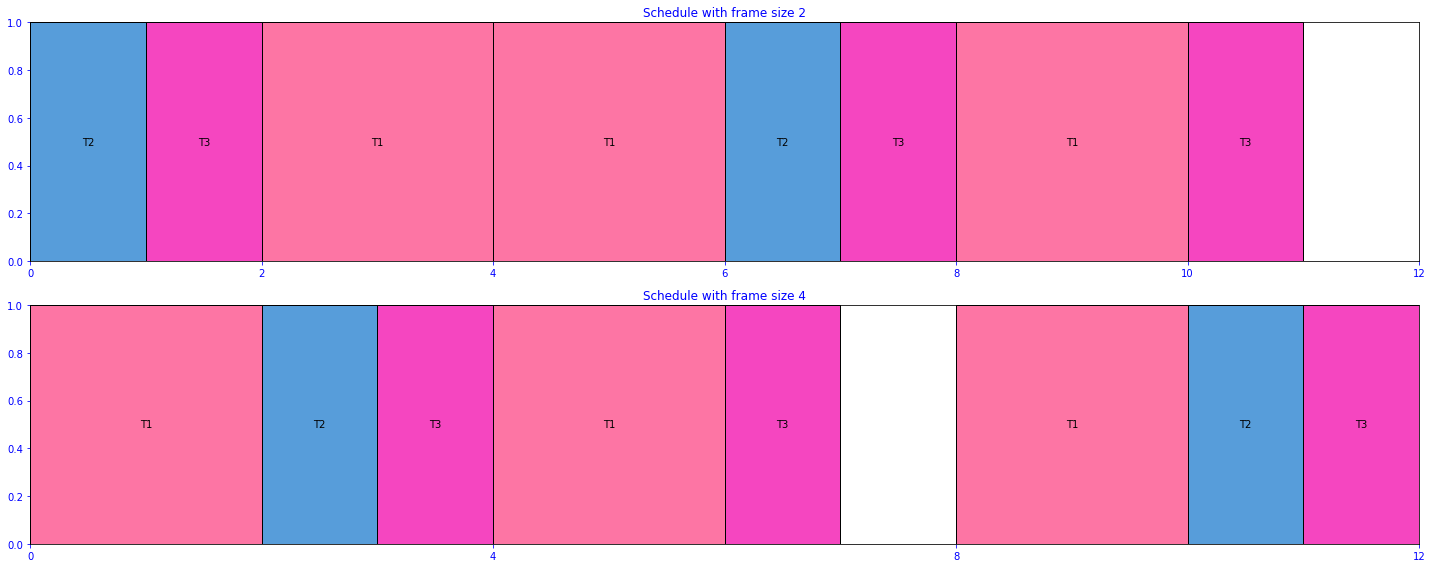

In [14]:
schedule.plotSchedule()

In [11]:
#To generate cpp, and header file 
#You can call scheduleTasks() function (of struct where all tasks are defined)
# in your system tick timer interrupt to do basic scheduling implementation

#schedule.generate_all_files()